In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import tensorflow as tf
import numpy as np
import albumentations as A
from sklearn.decomposition import PCA
from tensorflow.keras import optimizers



class PCAPlotter(tf.keras.callbacks.Callback):
    
    def __init__(self, plt, embedding_model, x_test, y_test):
        super(PCAPlotter, self).__init__()
        self.embedding_model = embedding_model
        self.x_test = x_test
        self.y_test = y_test
        self.fig = plt.figure(figsize=(9, 4))
        self.ax1 = plt.subplot(1, 2, 1)
        self.ax2 = plt.subplot(1, 2, 2)
        plt.ion()
        
        self.losses = []
    
    def plot(self, epoch=None, plot_loss=False):
        x_test_embeddings = self.embedding_model.predict(self.x_test)
        pca_out = PCA(n_components=2).fit_transform(x_test_embeddings)
        self.ax1.clear()
        self.ax1.scatter(pca_out[:, 0], pca_out[:, 1], c=self.y_test, cmap='seismic')
        if plot_loss:
            self.ax2.clear()
            self.ax2.plot(range(epoch), self.losses)
            self.ax2.set_xlabel('Epochs')
            self.ax2.set_ylabel('Loss')
        self.fig.canvas.draw()
    
    def on_train_begin(self, logs=None):
        self.losses = []
        self.fig.show()
        self.fig.canvas.draw()
        self.plot()
        
    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.plot(epoch+1, plot_loss=True)


In [ ]:
%matplotlib inline


import matplotlib.pyplot as plt
import random
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense,Conv2D,Dropout,Input,GlobalAveragePooling2D,MaxPooling2D
#from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import resnet
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from tensorflow.keras import backend, layers, metrics
from tensorflow.keras.layers import Input,Lambda
import cv2
# from pca_plotter import PCAPlotter

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.11.0


In [ ]:
inputShape=200
npzfile=np.load('/content/drive/MyDrive/Cigerate/cigerate_triplet .npz')

In [ ]:
image_pair=npzfile['arr_0']
image_label=npzfile['arr_1']

In [ ]:
from tensorflow.keras import regularizers

target_shape=(200,200)
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2=tf.keras.layers.Dropout(0.2)(dense2)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256,activation="sigmoid",)(dense2)


embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
N=256
class DistanceLayer(layers.Layer ):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative,N=256, beta=N, epsilon=1e-8):
        ap_distance = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),1)
        ap_distance=-tf.math.log(-tf.divide((ap_distance),beta)+1+epsilon)

        an_distance =  tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),1)
        an_distance=-tf.math.log(-tf.divide((N-an_distance),beta)+1+epsilon)

        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance + an_distance
        #loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
anchor   = []
positive = []
negative = []
actual=[]
for i in range(len(image_pair)):
  p, a, n=image_pair[i]
  actual.append(cv2.resize(a, (200,200)))
  anchor.append(tf.convert_to_tensor(cv2.resize(a, (200,200))))
  positive.append(tf.convert_to_tensor(cv2.resize(p, (200,200))))
  negative.append(tf.convert_to_tensor(cv2.resize(n, (200,200))))
  
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))

dataset = dataset.shuffle(buffer_size=500)


In [ ]:
example=actual[0]
a=np.expand_dims(example,axis=0)
print(a.shape)
example_emb=embedding.predict(preprocess_input(np.expand_dims(example,axis=0)))[0]
print(example_emb)

(1, 200, 200, 3)
1/1 [==============================] - 9s 9s/step
[0.4755216  0.8326202  0.10460629 0.8552493  0.21910687 0.8037609
 0.3335084  0.27121314 0.17654817 0.38790533 0.4423385  0.7062067
 0.21071498 0.06548086 0.5912805  0.38195893 0.43913293 0.24438822
 0.20792155 0.48761073 0.7269571  0.9199082  0.8013521  0.963831
 0.71619666 0.56877995 0.1881278  0.14267497 0.05223122 0.82426244
 0.5682259  0.85493153 0.5050915  0.17185108 0.6289616  0.6672788
 0.6275051  0.44770113 0.25137478 0.69042426 0.33652437 0.55980915
 0.18847977 0.76405346 0.5928804  0.5756237  0.5806215  0.4191717
 0.7925008  0.16396813 0.11193448 0.34440643 0.5964651  0.9198848
 0.7491985  0.10203055 0.4790609  0.16123542 0.670742   0.24320118
 0.19450706 0.7225517  0.16383688 0.13266797 0.6653052  0.27711955
 0.20517328 0.3952536  0.50597984 0.4835228  0.04030554 0.5285937
 0.25851873 0.14399593 0.8006857  0.15811042 0.37175176 0.3003461
 0.04864196 0.71609956 0.42871124 0.5013689  0.49078056 0.8314111
 0.57

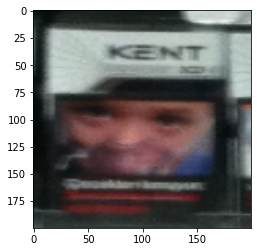

In [ ]:
imgplot = plt.imshow(actual[500])
plt.show()

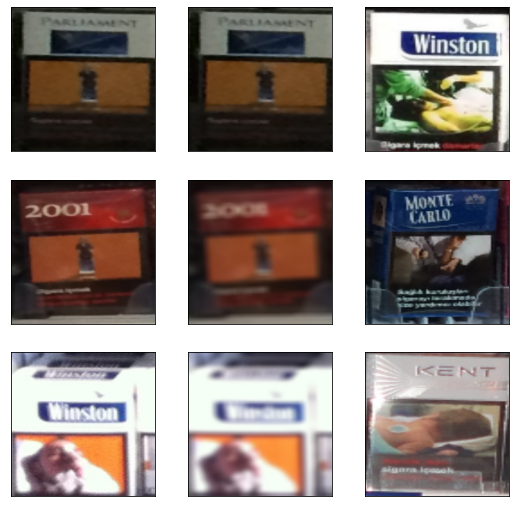

In [ ]:
#dataset = dataset.map(preprocess_triplets)


image_count = len(image_pair)
batch_size=128
# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(batch_size, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

86/86 [==============================] - 10s 84ms/step
Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 2.9965

18/18 [==============================] - 55s 2s/step - loss: 2.9965 - val_loss: 2.8297
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 2.6905

18/18 [==============================] - 36s 2s/step - loss: 2.6905 - val_loss: 2.5428
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 2.4253

18/18 [==============================] - 32s 2s/step - loss: 2.4253 - val_loss: 2.3056
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 2.1986

18/18 [==============================] - 36s 2s/step - loss: 2.1986 - val_loss: 2.1057
Epoch 5/50
18/18 [==============================] - ETA: 0s - loss: 2.0015

18/18 [==============================] - 36s 2s/step - loss: 2.0015 - val_loss: 1.9198
Epoch 6/50
18/18 [==============================] - ETA: 0s - loss: 1.8308

18/18 [==============================] - 36s 2s/step - loss: 1.8308 - val_loss: 1.7686
Epoch 7/50
18/18 [==============================] - ETA: 0s - loss: 1.6900

18/18 [==============================] - 36s 2s/step - loss: 1.6900 - val_loss: 1.6386
Epoch 8/50
18/18 [==============================] - ETA: 0s - loss: 1.5680

18/18 [==============================] - 36s 2s/step - loss: 1.5680 - val_loss: 1.5204
Epoch 9/50
18/18 [==============================] - ETA: 0s - loss: 1.4631

18/18 [==============================] - 36s 2s/step - loss: 1.4631 - val_loss: 1.4262
Epoch 10/50
18/18 [==============================] - ETA: 0s - loss: 1.3791

18/18 [==============================] - 33s 2s/step - loss: 1.3791 - val_loss: 1.3550
Epoch 11/50
18/18 [==============================] - ETA: 0s - loss: 1.3056

18/18 [==============================] - 33s 2s/step - loss: 1.3056 - val_loss: 1.2815
Epoch 12/50
18/18 [==============================] - ETA: 0s - loss: 1.2429

18/18 [==============================] - 33s 2s/step - loss: 1.2429 - val_loss: 1.2176
Epoch 13/50
18/18 [==============================] - ETA: 0s - loss: 1.1861

18/18 [==============================] - 33s 2s/step - loss: 1.1861 - val_loss: 1.1801
Epoch 14/50
18/18 [==============================] - ETA: 0s - loss: 1.1379

18/18 [==============================] - 36s 2s/step - loss: 1.1379 - val_loss: 1.1309
Epoch 15/50
18/18 [==============================] - ETA: 0s - loss: 1.0925

18/18 [==============================] - 33s 2s/step - loss: 1.0925 - val_loss: 1.1035
Epoch 16/50
18/18 [==============================] - ETA: 0s - loss: 1.0578

18/18 [==============================] - 33s 2s/step - loss: 1.0578 - val_loss: 1.0702
Epoch 17/50
18/18 [==============================] - ETA: 0s - loss: 1.0239

18/18 [==============================] - 36s 2s/step - loss: 1.0239 - val_loss: 1.0366
Epoch 18/50
18/18 [==============================] - ETA: 0s - loss: 0.9952

18/18 [==============================] - 32s 2s/step - loss: 0.9952 - val_loss: 1.0001
Epoch 19/50
18/18 [==============================] - ETA: 0s - loss: 0.9692

18/18 [==============================] - 36s 2s/step - loss: 0.9692 - val_loss: 0.9840
Epoch 20/50
18/18 [==============================] - ETA: 0s - loss: 0.9431

18/18 [==============================] - 36s 2s/step - loss: 0.9431 - val_loss: 0.9651
Epoch 21/50
18/18 [==============================] - ETA: 0s - loss: 0.9195

18/18 [==============================] - 36s 2s/step - loss: 0.9195 - val_loss: 0.9572
Epoch 22/50
18/18 [==============================] - ETA: 0s - loss: 0.9019

18/18 [==============================] - 32s 2s/step - loss: 0.9019 - val_loss: 0.9166
Epoch 23/50
18/18 [==============================] - ETA: 0s - loss: 0.8789

18/18 [==============================] - 36s 2s/step - loss: 0.8789 - val_loss: 0.9114
Epoch 24/50
18/18 [==============================] - ETA: 0s - loss: 0.8669

18/18 [==============================] - 32s 2s/step - loss: 0.8669 - val_loss: 0.8916
Epoch 25/50
18/18 [==============================] - ETA: 0s - loss: 0.8496

18/18 [==============================] - 36s 2s/step - loss: 0.8496 - val_loss: 0.8834
Epoch 26/50
18/18 [==============================] - ETA: 0s - loss: 0.8351

18/18 [==============================] - 36s 2s/step - loss: 0.8351 - val_loss: 0.8631
Epoch 27/50
18/18 [==============================] - ETA: 0s - loss: 0.8212

18/18 [==============================] - 36s 2s/step - loss: 0.8212 - val_loss: 0.8574
Epoch 28/50
18/18 [==============================] - ETA: 0s - loss: 0.8086

18/18 [==============================] - 36s 2s/step - loss: 0.8086 - val_loss: 0.8474
Epoch 29/50
18/18 [==============================] - ETA: 0s - loss: 0.7926

18/18 [==============================] - 33s 2s/step - loss: 0.7926 - val_loss: 0.8388
Epoch 30/50
18/18 [==============================] - ETA: 0s - loss: 0.7859

18/18 [==============================] - 32s 2s/step - loss: 0.7859 - val_loss: 0.8104
Epoch 31/50
18/18 [==============================] - ETA: 0s - loss: 0.7756

18/18 [==============================] - 36s 2s/step - loss: 0.7756 - val_loss: 0.8161
Epoch 32/50
18/18 [==============================] - ETA: 0s - loss: 0.7639

18/18 [==============================] - 36s 2s/step - loss: 0.7639 - val_loss: 0.8022
Epoch 33/50
18/18 [==============================] - ETA: 0s - loss: 0.7528

18/18 [==============================] - 32s 2s/step - loss: 0.7528 - val_loss: 0.7994
Epoch 34/50
18/18 [==============================] - ETA: 0s - loss: 0.7418

18/18 [==============================] - 36s 2s/step - loss: 0.7418 - val_loss: 0.7873
Epoch 35/50
18/18 [==============================] - ETA: 0s - loss: 0.7346

18/18 [==============================] - 36s 2s/step - loss: 0.7346 - val_loss: 0.7859
Epoch 36/50
18/18 [==============================] - ETA: 0s - loss: 0.7241

18/18 [==============================] - 36s 2s/step - loss: 0.7241 - val_loss: 0.7529
Epoch 37/50
18/18 [==============================] - ETA: 0s - loss: 0.7213

18/18 [==============================] - 33s 2s/step - loss: 0.7213 - val_loss: 0.7484
Epoch 38/50
18/18 [==============================] - ETA: 0s - loss: 0.7136

18/18 [==============================] - 36s 2s/step - loss: 0.7136 - val_loss: 0.7512
Epoch 39/50
18/18 [==============================] - ETA: 0s - loss: 0.7083

18/18 [==============================] - 36s 2s/step - loss: 0.7083 - val_loss: 0.7618
Epoch 40/50
18/18 [==============================] - ETA: 0s - loss: 0.6995

18/18 [==============================] - 36s 2s/step - loss: 0.6995 - val_loss: 0.7365
Epoch 41/50
18/18 [==============================] - ETA: 0s - loss: 0.6941

18/18 [==============================] - 33s 2s/step - loss: 0.6941 - val_loss: 0.7395
Epoch 42/50
18/18 [==============================] - ETA: 0s - loss: 0.6854

18/18 [==============================] - 33s 2s/step - loss: 0.6854 - val_loss: 0.7479
Epoch 43/50
18/18 [==============================] - ETA: 0s - loss: 0.6832

18/18 [==============================] - 33s 2s/step - loss: 0.6832 - val_loss: 0.7434
Epoch 44/50
18/18 [==============================] - ETA: 0s - loss: 0.6763

18/18 [==============================] - 33s 2s/step - loss: 0.6763 - val_loss: 0.7168
Epoch 45/50
18/18 [==============================] - ETA: 0s - loss: 0.6756

18/18 [==============================] - 36s 2s/step - loss: 0.6756 - val_loss: 0.7129
Epoch 46/50
18/18 [==============================] - ETA: 0s - loss: 0.6663

18/18 [==============================] - 36s 2s/step - loss: 0.6663 - val_loss: 0.7274
Epoch 47/50
18/18 [==============================] - ETA: 0s - loss: 0.6646

18/18 [==============================] - 32s 2s/step - loss: 0.6646 - val_loss: 0.7131
Epoch 48/50
18/18 [==============================] - ETA: 0s - loss: 0.6563

18/18 [==============================] - 36s 2s/step - loss: 0.6563 - val_loss: 0.7038
Epoch 49/50
18/18 [==============================] - ETA: 0s - loss: 0.6572

18/18 [==============================] - 32s 2s/step - loss: 0.6572 - val_loss: 0.6949
Epoch 50/50
18/18 [==============================] - ETA: 0s - loss: 0.6534

18/18 [==============================] - 36s 2s/step - loss: 0.6534 - val_loss: 0.7035


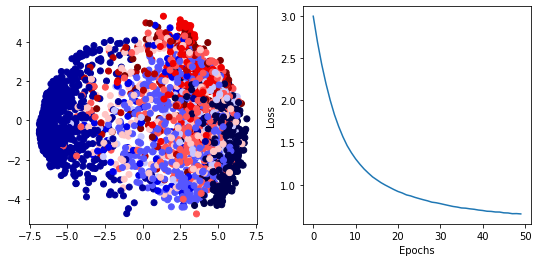

In [ ]:
early_stop=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
)


siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(learning_rate=0.000001,))
siamese_model.fit(train_dataset, epochs=50, validation_data=val_dataset,callbacks=[PCAPlotter(plt,embedding,np.array(actual),image_label),
        early_stop
    ])

In [ ]:
embedding.save('/content/drive/MyDrive/Cigerate/resnet_model' + '.h5')